# Setup

In [3]:
# Load model directly
try:
    import google.colab
    dev = "cuda"
    %pip install transformers
except:
    dev = "mps"

from typing import Literal
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel

from tqdm import tqdm
import torch

model_type = 'sbert' # or 'sbert'
model_name =  {
    'bert': "dmis-lab/biobert-base-cased-v1.2",
    'sbert': "pritamdeka/S-BioBert-snli-multinli-stsb"
}

if model_type == 'bert':
    tokenizer = AutoTokenizer.from_pretrained(model_name[model_type])
    model = AutoModel.from_pretrained(model_name[model_type])
else:
    model = SentenceTransformer(model_name[model_type])

model = model.to(dev)

sentences = ["This is an example sentence", "Each sentence is converted"]

def mean_pool(hidden_states, attention_mask):
    # Create mask for non-padding tokens
    mask = attention_mask.unsqueeze(-1).expand(hidden_states.size()).float()
    # Sum all non-padding token embeddings
    summed = torch.sum(hidden_states * mask, dim=1)
    # Count non-padding tokens
    count = torch.clamp(mask.sum(1), min=1e-9)
    # Calculate mean
    return summed / count

if model_type == 'sbert':
    embeddings = model.encode(sentences, convert_to_tensor=True, device=dev).cpu().numpy()
else:
    inputs = tokenizer(sentences, return_tensors="pt", padding=True)
    with torch.no_grad():
        inputs = inputs.to(dev)
        outputs = model(**inputs)
    embeddings = mean_pool(outputs.last_hidden_state, inputs['attention_mask']).cpu().numpy()


embeddings.shape



(2, 768)

In [6]:
from pathlib import Path
import re
import pandas as pd

base_path = Path("./go-basic/")

no_information = re.compile(r"molecular_function|biological_process|cellular_component|preferred_label")

annots = {}
with open(base_path / "cache"/ "annotations.txt", "r") as f:
  for line in f:
    uri, annot = line.split(maxsplit=1)

    annot_clean = no_information.sub("", annot)

    go_id = uri.split("/")[-1]
    if go_id not in annots or len(annots[go_id]) < len(annot_clean):
      annots[go_id] = annot_clean


annot_srs = pd.Series(annots).filter(regex="^GO")

annot_srs.sort_values(key=lambda x: x.str.len(), ascending=True)[:20]


GO_1901640         Binding to XTP.\n
GO_1901641         Binding to ITP.\n
GO_2001062       Binding to xylan.\n
GO_1904067      Binding to ascr#2.\n
GO_0044589      Binding to pectin.\n
GO_0097645      Binding to amylin.\n
GO_2001082      Binding to inulin.\n
GO_2001070      Binding to starch.\n
GO_0002058      Binding to uracil.\n
GO_0002057     Binding to guanine.\n
GO_0030977     Binding to taurine.\n
GO_0008289     Binding to a lipid.\n
GO_1901982     Binding to maltose.\n
GO_0002059     Binding to thymine.\n
GO_1901973     Binding to proline.\n
GO_2001065     mannoglycan binding\n
GO_0035473    Binding to a lipase.\n
GO_1903794    Binding to cortisol.\n
GO_0002056    Binding to cytosine.\n
GO_1901691    hydrogen ion binding\n
dtype: object

In [50]:
all_lines = []
for file in base_path.glob("split/*.csv"):
  with open(file) as f:
    for line in f:
      all_lines.append(line.strip())

all_gos = set(line.split(',')[0] for line in all_lines) | set(line.split(',')[1] for line in all_lines)

In [51]:
missing_gos = [go for go in all_gos if go.split('/')[-1] not in annots]

len(missing_gos), len(all_gos)


(2074, 47050)

# Calculate Embeddings

In [52]:
import gc
from pathlib import Path
import numpy as np


n = 0
def clean_memory():
    global n
    gc.collect()
    n += 1
    if n % 3 == 0:
      torch.mps.empty_cache()  # for MPS (Apple Silicon)
    # If using CUDA, use: torch.cuda.empty_cache()



keys = list(annots.keys())

sentences = [annots[key] for key in keys]

# Process and save in batches
batch_size = 512
save_every = 1000  # Save after processing this many samples
embeddings = []
save_path = base_path / f"{model_type}"
save_path.mkdir(exist_ok=True)

for i in tqdm(range(0, len(sentences), batch_size), desc="Processing batches"):
    clean_memory()

    batch = sentences[i:i + batch_size]
    if model_type == 'sbert':
        batch_embeddings = model.encode(batch, convert_to_tensor=True, device=dev).cpu().numpy()
    else:
        inputs = tokenizer(
            batch,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512
        ).to(dev)

        with torch.no_grad():
            outputs = model(**inputs)
        # Mean pool the output
        batch_embeddings = mean_pool(
            outputs.last_hidden_state,
            inputs['attention_mask']
        ).cpu().numpy()

    embeddings.extend(batch_embeddings)

    # Save partial progress
    if len(embeddings) >= save_every:
        batch_num = i // save_every
        np.save(
            save_path / f"embeddings_batch_{batch_num}.npy",
            np.array(embeddings)
        )
        embeddings = []  # Clear list after saving

# Save any remaining embeddings
if embeddings:
    batch_num = len(sentences) // save_every
    np.save(
        save_path / f"embeddings_batch_{batch_num}.npy",
        np.array(embeddings)
    )




Processing batches: 100%|██████████| 106/106 [03:28<00:00,  1.97s/it]


In [53]:
# Get all embedding files and sort by batch number
embedding_files = list(save_path.glob("embeddings_batch_*.npy"))
embedding_files.sort(key=lambda x: int(str(x).split("_")[-1].split(".")[0]))

# Load and concatenate all embeddings
all_embeddings = []
for file in embedding_files:
    batch_embeddings = np.load(file)
    all_embeddings.append(batch_embeddings)

# Create dict mapping keys to embeddings
final_embeddings = np.concatenate(all_embeddings, axis=0)
embeddings_dict = {key: emb for key, emb in zip(keys, final_embeddings)}

# Save final merged embeddings dict
np.save(save_path / "ontology.embeddings.npy", embeddings_dict)

# Clean up intermediate files
for file in embedding_files:
    file.unlink()

print(f"Saved merged embeddings with shape: {final_embeddings.shape}")




Saved merged embeddings with shape: (54217, 768)

# Tokenizer token loss

In [9]:
from rich import print, inspect

keys = list(annots.keys())

sentences = [annots[key] for key in keys]
toks = model._modules['0'].tokenizer(sentences)['input_ids']



Token indices sequence length is longer than the specified maximum sequence length for this model (106 > 75). Running this sequence through the model will result in indexing errors


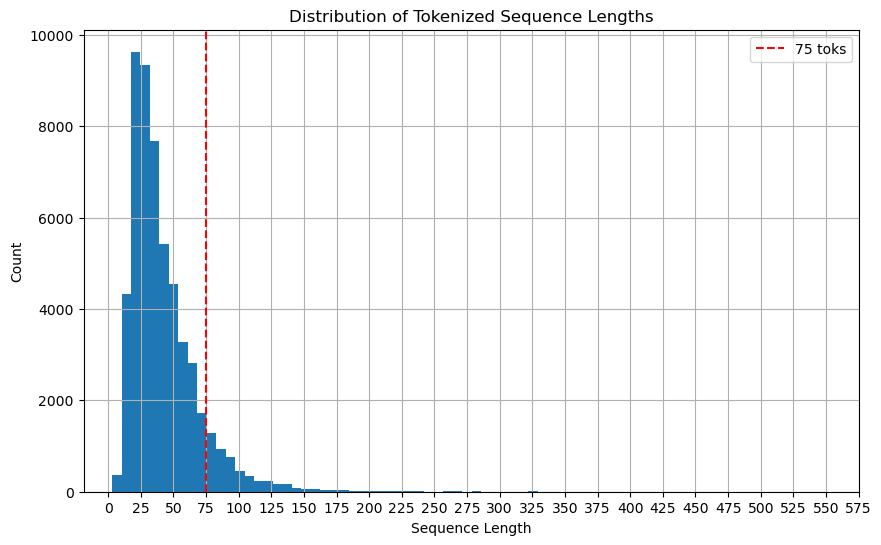

Min length: 3 toks

Max length: 438 toks

Mean length: 42.1 toks

Sentences with lost information: 5094/54217

Average toks lost: 29.3 toks/sentence

In [16]:
# Get lengths of each tokenized sequence
lengths = [len(t) for t in toks]
import matplotlib.pyplot as plt
import numpy as np


# Create histogram
plt.figure(figsize=(10,6))
plt.hist(lengths, bins=60)
plt.xticks(range(0, 600, 25))
plt.xlabel('Sequence Length')
plt.ylabel('Count')
plt.title('Distribution of Tokenized Sequence Lengths')
plt.axvline(75, color='red', linestyle='--', label='75 toks')
plt.legend()
plt.grid(True)
plt.show()

print(f"Min length: {min(lengths)} toks")
print(f"Max length: {max(lengths)} toks")
print(f"Mean length: {np.mean(lengths):.1f} toks")
print(f"Sentences with lost information: {sum(1 for l in lengths if l > 75)}/{len(lengths)}")
print(f"Average toks lost: {(sum(l - 75 for l in lengths if l > 75) / sum(1 for l in lengths if l > 75)):.1f} toks/sentence")


In [10]:
len(np.load(save_path / "ontology.embeddings.npy", allow_pickle=True).item().keys())


54217

# Graph Checks (Deprecated, etc.)

In [42]:
import rdflib

g = rdflib.Graph()
g.parse("go-basic.owl")



<Graph identifier=N01921ccfb5bb48daa5c94d94c9f17a8c (<class 'rdflib.graph.Graph'>)>

In [46]:
len([s for s in set(g.objects()) | set(g.subjects()) if not isinstance(s, rdflib.Literal)])


196733

In [49]:

go_terms = set()
GO = rdflib.Namespace("http://purl.obolibrary.org/obo/GO_")
for s, p, o in g:
    # Check subject
    if isinstance(s, rdflib.URIRef) and str(s).startswith(str(GO)):
        go_terms.add(s)
    # Check object
    if isinstance(o, rdflib.URIRef) and str(o).startswith(str("GO")):
        go_terms.add(o)

len(go_terms)


51550

In [39]:

# Get annotations for missing GO terms from the graph
total_deprecated = 0
for go_uri in missing_gos:
    go_id = go_uri.split('/')[-1]

    # Get all objects (annotations) for this GO term
    for s, p, o in g.triples((rdflib.URIRef(go_uri), None, None)):
        #print(s, p, o)
        if p == rdflib.URIRef('http://www.w3.org/2002/07/owl#deprecated'):
          total_deprecated += 1
        # Check if predicate is a label or definition
        if p in [rdflib.URIRef('http://www.w3.org/2000/01/rdf-schema#label'),
                rdflib.URIRef('http://purl.obolibrary.org/obo/IAO_0000115')]:
            if go_id not in annots:
                annots[go_id] = ""
            # Add the literal value to annotations
            if isinstance(o, rdflib.Literal):
                annots[go_id] += str(o) + " "

total_deprecated


2131